In [147]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import datetime

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [12, 6]

In [2]:
data_path = "../data/origineel"

if not Path(data_path).is_dir():
    raise Warning("Data path does not exist")


# Dataset laden

In [35]:
# Lijst van .csv-bestanden
data_file_paths = [path for path in Path(data_path).iterdir() if path.suffix==".csv"]

# Geef het circuitnummer (4 cijfers) dat in de naam van een Path staat
circuitnum_from_file_path = lambda file_path: int(file_path.name.split('-')[0])

# Drie dictionaries, met als keys de circuitnummers (int), als value de Pandas DataFrame van de .csv.
cable_config       = {circuitnum_from_file_path(fp): pd.read_csv(fp, sep=";") for fp in data_file_paths if 'cableconfig' in fp.name}
partial_discharges = {circuitnum_from_file_path(fp): pd.read_csv(fp, sep=";") for fp in data_file_paths if 'pd' in fp.name}
warning            = {circuitnum_from_file_path(fp): pd.read_csv(fp, sep=";") for fp in data_file_paths if 'warning' in fp.name}

# Sla de keys op van alle kabels waarvoor PD data bestaat.
circuits = list(cable_config)

In [32]:
print("Cable config loaded for circuits:", list(cable_config))
print("   PD series loaded for circuits:", list(partial_discharges))
print("Warning logs loaded for circuits:", list(warning))

Cable config loaded for circuits: [1512, 2063, 2145, 2806, 2870, 2979, 2980, 3010]
   PD series loaded for circuits: [1512, 2063, 2145, 2806, 2870, 2979, 2980, 3010]
Warning logs loaded for circuits: [1512, 2063, 2145, 2806, 2870]


# Analyse
We kiezen eerst een circuit uit.

In [293]:
# Kies een circuit uit
circ = circuits[1]

# Lengte van de kabel is gegeven in de cable config
cable_length = cable_config[circ]['Cumulative length (m)'].values[-1]


pd = partial_discharges[circ]

# Sla de drie kolomnamen van PD voor het gemak op
datetimeC, locC, chargeC = pd.columns

# Lijst met bools die aangeeft of er op dat tijdstip een PD was
pd_occured = ~np.isnan(pd[locC])

# De drie kolommen; alleen op tijdstippen met PD
locations = pd[locC][pd_occured]
charges = pd[chargeC][pd_occured]
times = pd[datetimeC][pd_occured].apply(datetime.datetime.fromisoformat)

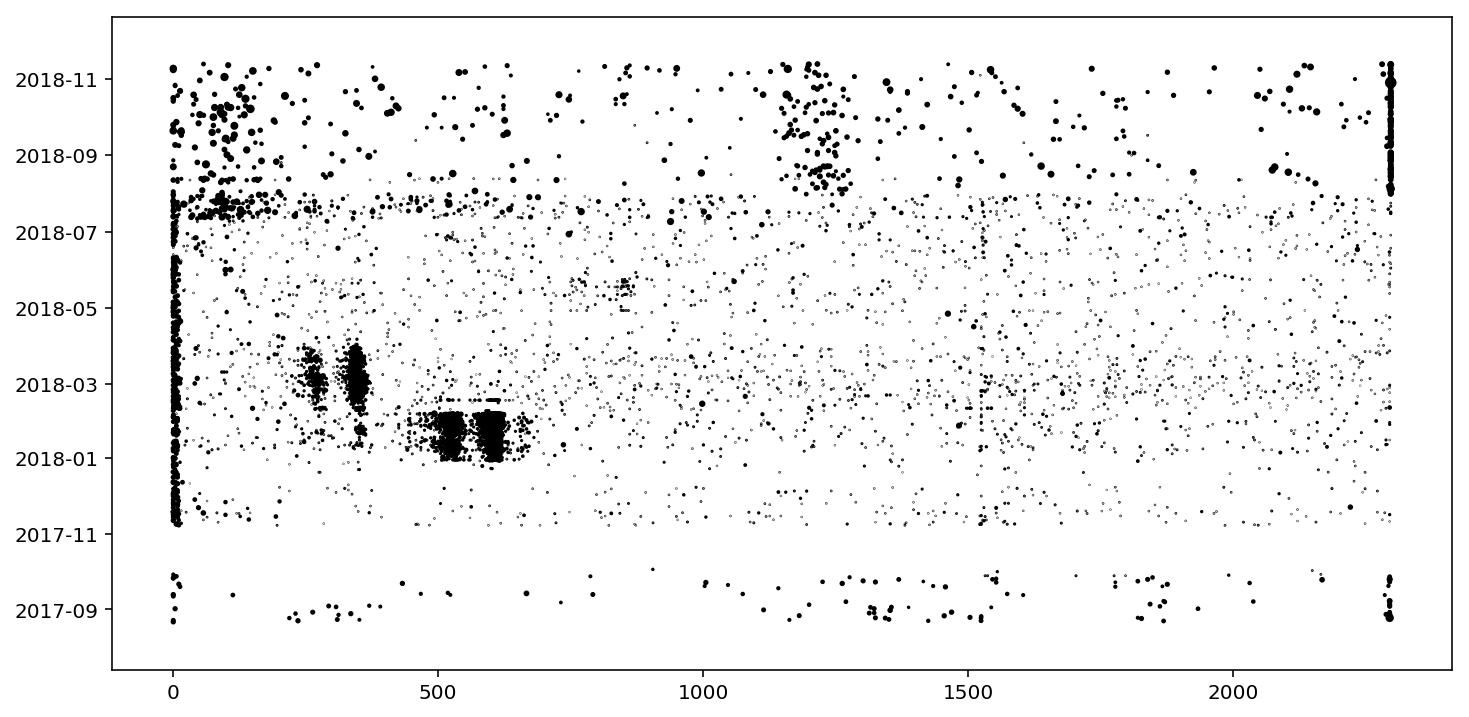

In [294]:
plt.scatter(x=locations, y=times, s=charges/1e4, c='.0')
plt.show()

# Afstand discretiseren

In de data is afstand continu, dwz dat er (waarschijnlijk)\* geen twee PDs op precies dezelfde locatie plaatsvinden. Je kan dus nog niet praten over het 'aantal PDs op x meter'. Het lijkt dus nuttig om de afstand te discretiseren: opsplitsen in een eindig aantal 'bins', waarin elke PD-locatie valt.

\* Dit is niet helemaal waar, het aantal unieke locaties is ongeveer een tiende van het aantal PDs. Er is dus waarschijnlijk al gediscretiseerd, het lijkt elke 25cm te zijn.

In [295]:
# Grootte van bins
bin_size = 4.0 # meter

bins = np.arange(start=0., stop=cable_length, step=bin_size)

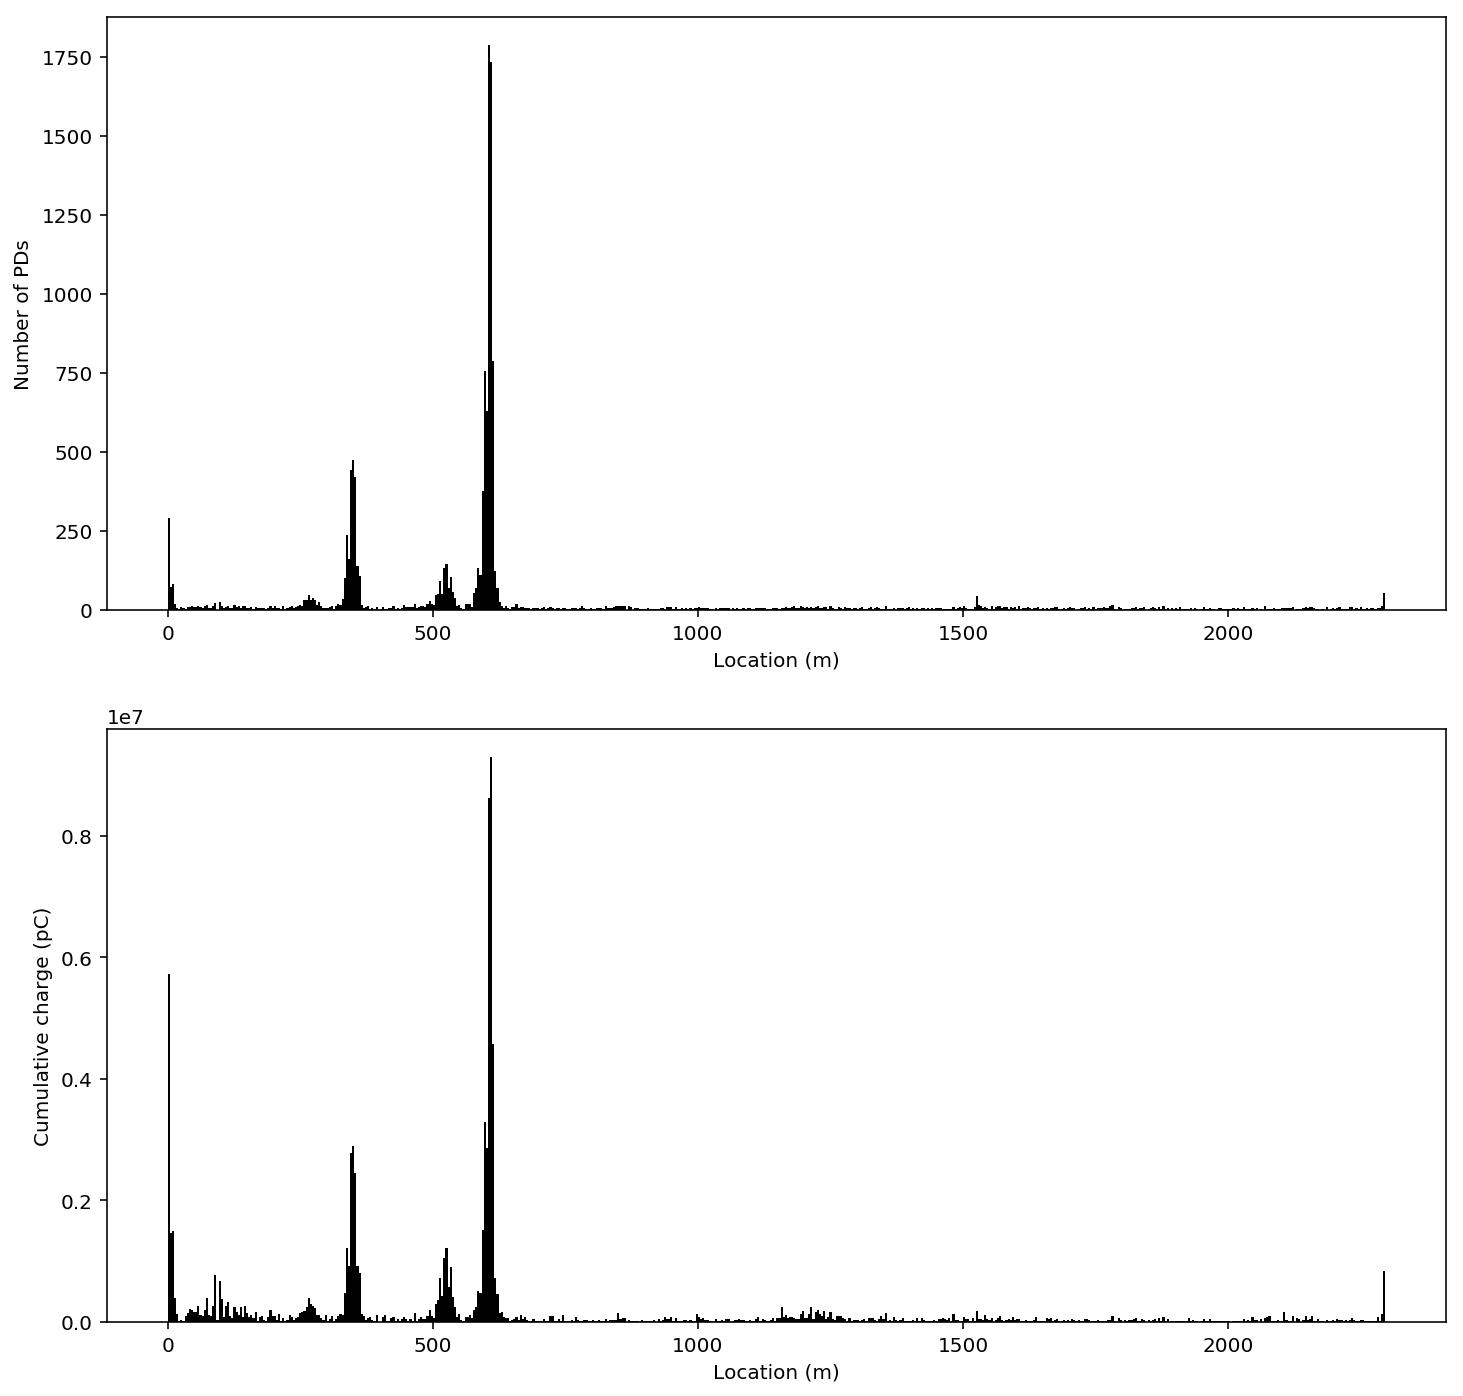

In [296]:
# Tel inhoud van elk bakje:
binned_pds, _ = np.histogram(locations, bins=bins, weights=charges)

fig = plt.figure(figsize=(12,12))

plt.subplot(2,1,1)
plt.hist(locations,bins=bins,color='0')
plt.xlabel("Location (m)")
plt.ylabel("Number of PDs")
plt.subplot(2,1,2)
plt.hist(locations,bins=bins, weights=charges,color='0')
plt.xlabel("Location (m)")
plt.ylabel("Cumulative charge (pC)")
plt.show()

## Aanname 1:
Met het grootste gedeelte van de lijn is niks aan de hand. We kiezen een **ondergrens voor het percentage locaties waarop niks aan de hand is**.

In [297]:
lower_limit_nominal = 90.0/100.0

Sorteer de bakjes op inhoud, en beschouw de $\eta=0.9=$90% van de bakjes met de minste inhoud. De grens die we empirisch vinden noemen we $M_{\eta}$.

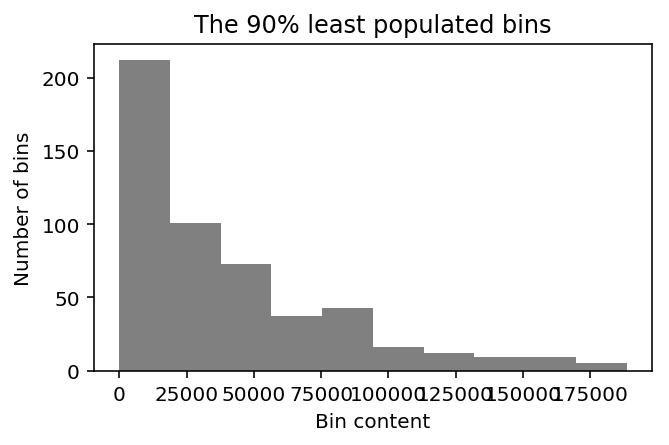

In [298]:
nominal_pd_level = np.sort(binned_pds)[int(lower_limit_nominal * len(binned_pds))]

plt.figure(figsize=(5,3))

plt.hist(binned_pds[binned_pds <= nominal_pd_level],color='.5')
plt.xlabel("Bin content")
plt.ylabel("Number of bins")
plt.title("The {:.0%} least populated bins".format(lower_limit_nominal))
plt.show()

Waar zit die 10%?

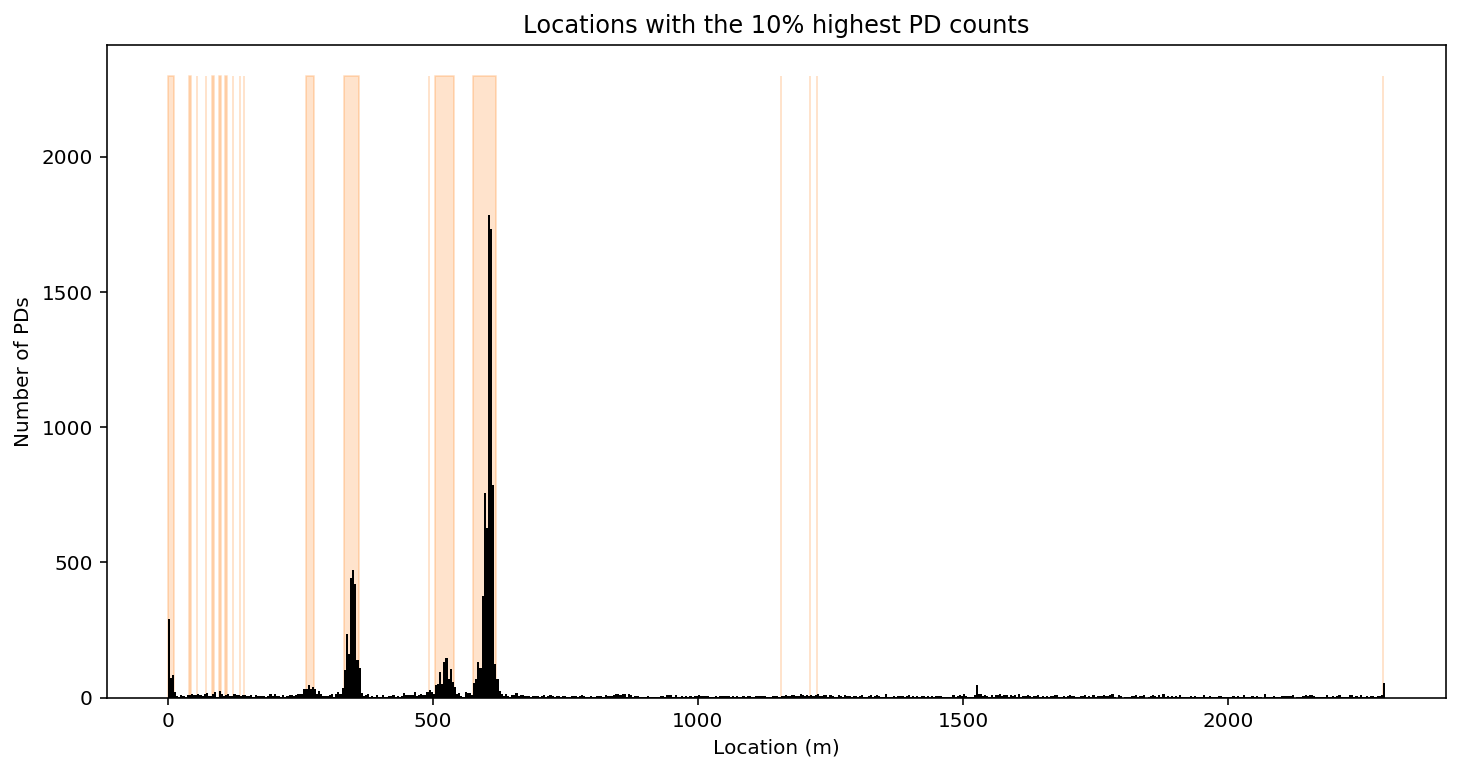

In [299]:
plt.hist(locations,bins=bins,color='0')
plt.xlabel("Location (m)")
plt.ylabel("Number of PDs")
plt.title("Locations with the 10% highest PD counts")

plt.fill_between(bins[:-1], 0, np.max(locations), where=binned_pds>nominal_pd_level, color='#ff7700',alpha=.2)

plt.show()


## Wilde aanname 2:
Het aantal PDs $X$ _op een nominaal stuk lijn_ is Poisson-verdeeld, $X \sim P(\lambda)$. Zó dat:

$$\mathbb{E}[X \leq M_{\eta}] = \eta.$$

(De kans dat X binnen de empirisch bepaalde 90% grens valt is exact 90%.)
Dit betekent dat als we veel samples uit deze Poisson-verdeling nemen, en we zoeken de grens van 90%, dan vinden we dezelfde $M_{\eta}$ en dan zouden we dezelfde $\lambda$ kiezen.

### Berekening $\lambda$

We kunnen de Poisson-verdling met parameter $\lambda$ schatten met een normaalverdeling $N(\mu = \lambda, \sigma^2 = \lambda)$. Stel $Y$ is zo verdeeld.

$$\mathbb{E}[Y \leq M_{\eta}] = \mathbb{E}[N(0,\lambda) \leq M_{\eta} - \lambda] = \mathbb{E}[N(0,1) \leq M_{\eta}/\sqrt{\lambda} - \sqrt{\lambda}] = \eta$$.

Dus $M_{\eta}/\sqrt{\lambda} - \sqrt{\lambda} = \Phi(\eta)$ en

$$\lambda = \frac{1}{4}\left(-\Phi(\eta) + \sqrt{\Phi(\eta)^2 + 4M_{\eta}}\right)^2.$$

($\Phi$ is de inverse van de verdelingsfunctie(?) (CDF) van de standaard normaalverdeling.)

In [300]:
square = lambda x: x*x

phieta = scipy.stats.norm.ppf(q=lower_limit_nominal)
rate = .25*square(-phieta + np.sqrt(square(phieta) + 4*nominal_pd_level))

rate

187937.92422804039

## Wilde aanname 3:
Op plekken waar een fout zit is het aantal PDs _abnormaal hoog, volgens de gevonden Poisson-verdeling_. Abnormaal = 1 op 100?

In [301]:
lower_limit_fault = 99.0 / 100.0

In [302]:
# Als ik de ppf van de scipy.stats.poisson gebruik krijg ik alleen maar resultaten heel dichtbij M_{\eta}
# dat hoort niet (toch?)
fault_pd_level = scipy.stats.norm.ppf(q=lower_limit_fault, loc=rate, scale=rate)

fault_pd_level

625146.9147075908

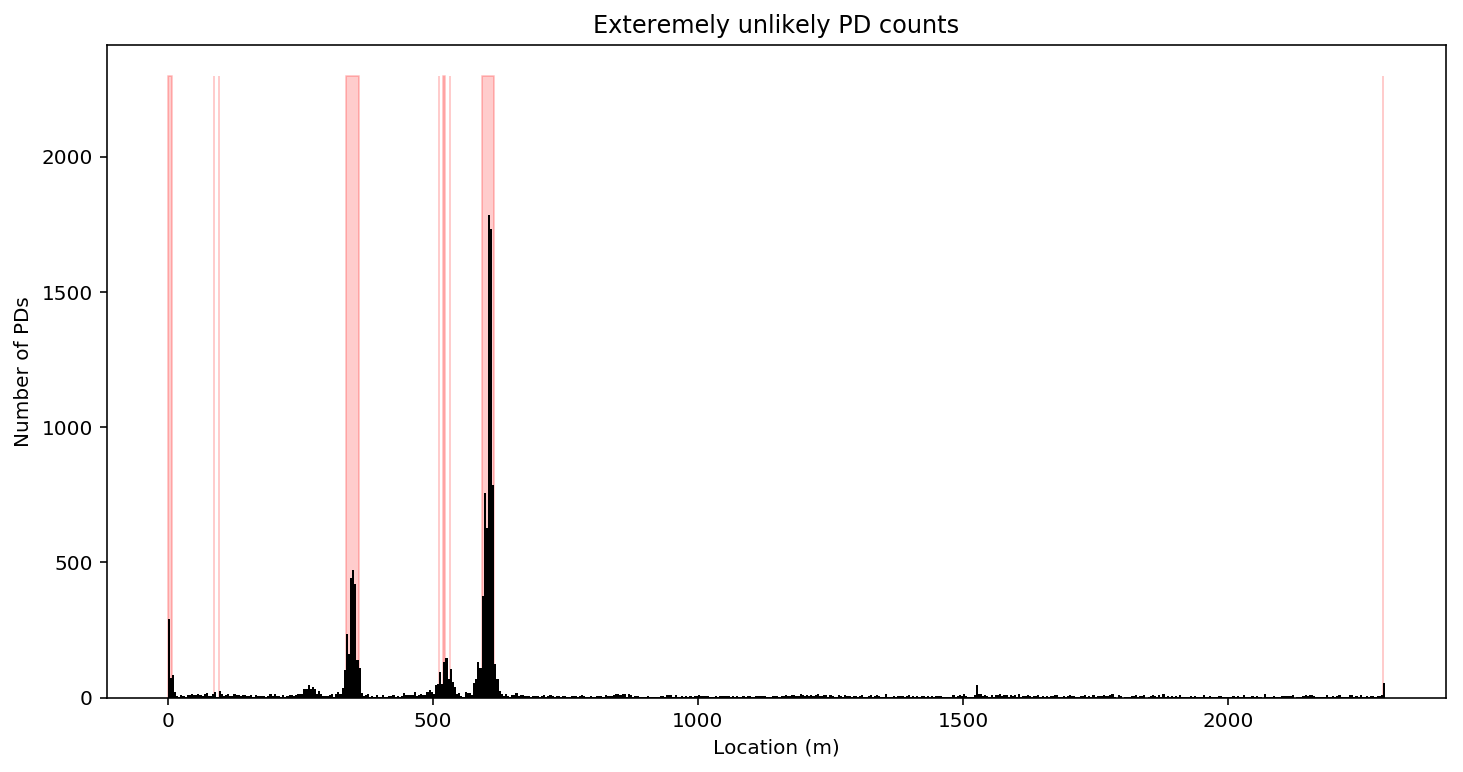

In [303]:
plt.hist(locations,bins=bins,color='0')
plt.xlabel("Location (m)")
plt.ylabel("Number of PDs")
plt.title("Exteremely unlikely PD counts")

plt.fill_between(bins[:-1], 0, np.max(locations), where=binned_pds>fault_pd_level, color='r',alpha=.2)

plt.show()

# Een simpel clusteralgortime

We hebben nu een deelverzameling $W$ van de locaties van de bakjes, waarop het aantal PDs met zekerheid abnormaal hoog is. Het is te zien dat bij pieken hier een rij opeenvolgende getallen in staat, maar soms mist er eentje.

We definieren een cluster dmv twee parameters:
* Een 'gat' in het cluster is maximaal $n_{skip} \in \mathbb{N}$ groot.
* Het cluster heeft minimaal $m_{min} \in \mathbb{N}$ elementen.



In [304]:
max_skip = 5
min_size = 5

In [305]:
def cluster_boolean_series(series, nskip=5, mmin=5):
    # Iteratief algoritme:
    clusters = set()
    cluster_start = 0
    gap_size = 0
    for i, x in enumerate(series):
        if x:
            if gap_size > nskip:
                # Einde cluster
                cluster_end = i - gap_size
                if cluster_end - cluster_start >= mmin:
                    # Cluster was groot genoeg:
                    clusters.add((cluster_start, cluster_end))
                cluster_start = i
            gap_size = 0
        if not x:
            gap_size += 1
    
    cluster_end = len(series) - gap_size
    if cluster_end - cluster_start >= mmin:
        # Cluster was groot genoeg:
        clusters.add((cluster_start, cluster_end))
    return clusters

Testjes algoritme:

In [306]:
print(cluster_boolean_series(np.array([1,1,1,0, 0, 1]) >= 1, nskip=1, mmin=1))
print(cluster_boolean_series(np.array([1,0,1,0, 0, 1]) >= 1, nskip=1, mmin=1))
print(cluster_boolean_series(np.array([1,0,1,0, 0, 1]) >= 1, nskip=2, mmin=1))

{(5, 6), (0, 3)}
{(5, 6), (0, 3)}
{(0, 6)}


Op onze data:

In [307]:
clusters = cluster_boolean_series(binned_pds >= fault_pd_level)
clusters

{(84, 91), (128, 134), (148, 155)}

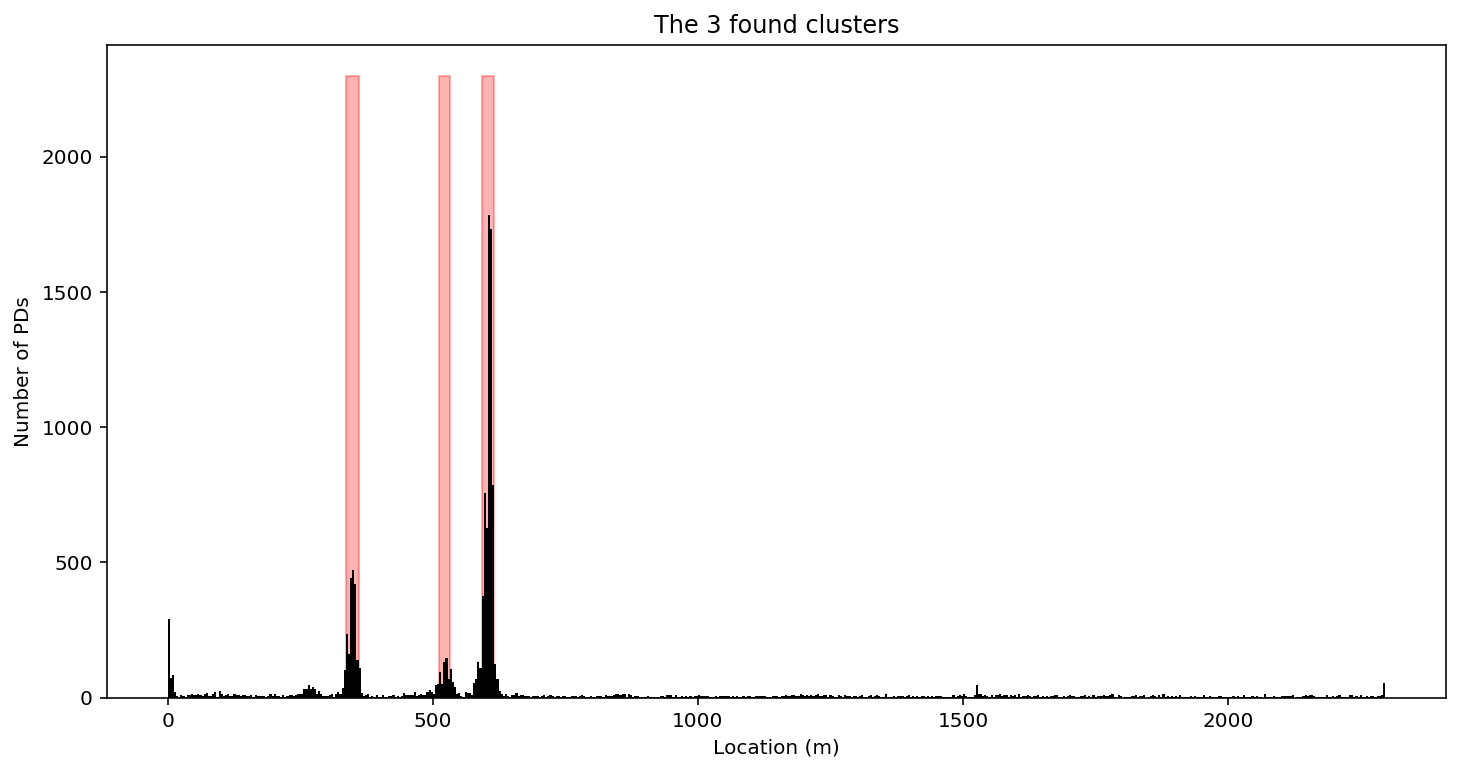

In [308]:
def inside_a_cluster(location):
    bin_index = int(location/bin_size)
    return any(a <= bin_index < b for a,b in clusters)

inside_a_cluster_v = np.vectorize(inside_a_cluster)


plt.hist(locations,bins=bins,color='0')
plt.xlabel("Location (m)")
plt.ylabel("Number of PDs")
plt.title("The {0} found clusters".format(len(clusters)))

plt.fill_between(bins[:-1], 0, np.max(locations), where=inside_a_cluster_v(bins[:-1]), color='r',alpha=.3)

plt.show()

# Conclusie

Het werkt goed!
Door eerst de 90% marge te zoeken, en dan de onderste 90% te gebruiken om een verdeling te fitten, kan de ruis _gebruikt worden om te bepalen hoe bijzonder de uitschieters zijn_. Hierdoor vindt het bijvoorbeeld 0 clusters in de laatste sets (wat de bedoeling is).

In het tweede circuit wordt een cluster niet gevonden. Ik denk dat dit is omdat dat cluster maar korte duur had, en daarom in de lange dataset minder opvalt. (Er wordt namelijk gesommeerd over de volledige tijdreeks.) Dit kan overkomen worden door het algoritme los toe te passen op elke maand, bijvoorbeeld.